In [ ]:
#| default_exp utils

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example Data

> The `core.NeuralForecast` class allows you to efficiently fit multiple `NeuralForecast` models for large sets of time series. It operates with pandas DataFrame `df` that identifies individual series and datestamps with the `unique_id` and `ds` columns, and the `y` column denotes the target time series variable. To assist development, we declare useful datasets that we use throughout all `NeuralForecast`'s unit tests.<br><br>

In [ ]:
#| export
import random
from itertools import chain
from typing import List, Union, Optional, Tuple
from utilsforecast.compat import DFType

import numpy as np
import pandas as pd

In [ ]:
#| hide
import matplotlib.pyplot as plt

from nbdev.showdoc import add_docs, show_doc

# 1. Synthetic Panel Data

In [ ]:
#| export
def generate_series(n_series: int,
                    freq: str = 'D',
                    min_length: int = 50,
                    max_length: int = 500,
                    n_temporal_features: int = 0,
                    n_static_features: int = 0,
                    equal_ends: bool = False,
                    seed: int = 0) -> pd.DataFrame:
    """Generate Synthetic Panel Series.

    Generates `n_series` of frequency `freq` of different lengths in the interval [`min_length`, `max_length`].
    If `n_temporal_features > 0`, then each serie gets temporal features with random values.
    If `n_static_features > 0`, then a static dataframe is returned along the temporal dataframe.
    If `equal_ends == True` then all series end at the same date.

    **Parameters:**<br>
    `n_series`: int, number of series for synthetic panel.<br>
    `min_length`: int, minimal length of synthetic panel's series.<br>
    `max_length`: int, minimal length of synthetic panel's series.<br>
    `n_temporal_features`: int, default=0, number of temporal exogenous variables for synthetic panel's series.<br>
    `n_static_features`: int, default=0, number of static exogenous variables for synthetic panel's series.<br>
    `equal_ends`: bool, if True, series finish in the same date stamp `ds`.<br>
    `freq`: str, frequency of the data, [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).<br>

    **Returns:**<br>
    `freq`: pandas.DataFrame, synthetic panel with columns [`unique_id`, `ds`, `y`] and exogenous.
    """
    seasonalities = {'D': 7, 'M': 12}
    season = seasonalities[freq]

    rng = np.random.RandomState(seed)
    series_lengths = rng.randint(min_length, max_length + 1, n_series)
    total_length = series_lengths.sum()

    dates = pd.date_range('2000-01-01', periods=max_length, freq=freq).values
    uids = [
        np.repeat(i, serie_length) for i, serie_length in enumerate(series_lengths)
    ]
    if equal_ends:
        ds = [dates[-serie_length:] for serie_length in series_lengths]
    else:
        ds = [dates[:serie_length] for serie_length in series_lengths]

    y = np.arange(total_length) % season + rng.rand(total_length) * 0.5
    temporal_df = pd.DataFrame(dict(unique_id=chain.from_iterable(uids),
                                    ds=chain.from_iterable(ds),
                                    y=y))

    random.seed(seed)
    for i in range(n_temporal_features):
        random.seed(seed)
        temporal_values = [
            [random.randint(0, 100)] * serie_length for serie_length in series_lengths
        ]
        temporal_df[f'temporal_{i}'] = np.hstack(temporal_values)
        temporal_df[f'temporal_{i}'] = temporal_df[f'temporal_{i}'].astype('category')
        if i == 0:
            temporal_df['y'] = temporal_df['y'] * \
                                  (1 + temporal_df[f'temporal_{i}'].cat.codes)

    temporal_df['unique_id'] = temporal_df['unique_id'].astype('category')
    temporal_df['unique_id'] = temporal_df['unique_id'].cat.as_ordered()

    if n_static_features > 0:
        static_features = np.random.uniform(low=0.0, high=1.0, 
                        size=(n_series, n_static_features))
        static_df = pd.DataFrame.from_records(static_features, 
                           columns = [f'static_{i}'for i in  range(n_static_features)])
        
        static_df['unique_id'] = np.arange(n_series)
        static_df['unique_id'] = static_df['unique_id'].astype('category')
        static_df['unique_id'] = static_df['unique_id'].cat.as_ordered()

        return temporal_df, static_df

    return temporal_df

In [ ]:
show_doc(generate_series, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/utils.py#L22){target="_blank" style="float:right; font-size:smaller"}

### generate_series

>      generate_series (n_series:int, freq:str='D', min_length:int=50,
>                       max_length:int=500, n_temporal_features:int=0,
>                       n_static_features:int=0, equal_ends:bool=False,
>                       seed:int=0)

*Generate Synthetic Panel Series.

Generates `n_series` of frequency `freq` of different lengths in the interval [`min_length`, `max_length`].
If `n_temporal_features > 0`, then each serie gets temporal features with random values.
If `n_static_features > 0`, then a static dataframe is returned along the temporal dataframe.
If `equal_ends == True` then all series end at the same date.

**Parameters:**<br>
`n_series`: int, number of series for synthetic panel.<br>
`min_length`: int, minimal length of synthetic panel's series.<br>
`max_length`: int, minimal length of synthetic panel's series.<br>
`n_temporal_features`: int, default=0, number of temporal exogenous variables for synthetic panel's series.<br>
`n_static_features`: int, default=0, number of static exogenous variables for synthetic panel's series.<br>
`equal_ends`: bool, if True, series finish in the same date stamp `ds`.<br>
`freq`: str, frequency of the data, [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).<br>

**Returns:**<br>
`freq`: pandas.DataFrame, synthetic panel with columns [`unique_id`, `ds`, `y`] and exogenous.*

In [ ]:
synthetic_panel = generate_series(n_series=2)
synthetic_panel.groupby('unique_id').head(4)

C:\Users\ospra\AppData\Local\Temp\ipykernel_16560\470716697.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  synthetic_panel.groupby('unique_id').head(4)


,unique_id,ds,y
0,0,2000-01-01,0.357595
1,0,2000-01-02,1.301382
2,0,2000-01-03,2.272442
3,0,2000-01-04,3.211827
222,1,2000-01-01,5.399023
223,1,2000-01-02,6.092818
224,1,2000-01-03,0.476396
225,1,2000-01-04,1.343744


In [ ]:
temporal_df, static_df = generate_series(n_series=1000, n_static_features=2,
                                         n_temporal_features=4, equal_ends=False)
static_df.head(2)

,static_0,static_1,unique_id
0,0.748805,0.573544,0
1,0.234966,0.235057,1


# 2. AirPassengers Data

The classic Box & Jenkins airline data. Monthly totals of international airline passengers, 1949 to 1960.

It has been used as a reference on several forecasting libraries, since it is a series that shows clear trends and seasonalities it offers a nice opportunity to quickly showcase a model's predictions performance.

In [ ]:
#| export
AirPassengers = np.array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
                          118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
                          114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
                          162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
                          209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
                          272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
                          302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
                          315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
                          318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
                          348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
                          362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
                          342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
                          417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
                          432.], dtype=np.float32)

In [ ]:
#| export
AirPassengersDF = pd.DataFrame({'unique_id': np.ones(len(AirPassengers)),
                                'ds': pd.date_range(start='1949-01-01',
                                                    periods=len(AirPassengers), freq=pd.offsets.MonthEnd()),
                                'y': AirPassengers})

In [ ]:
AirPassengersDF.head(12)

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
5,1.0,1949-06-30,135.0
6,1.0,1949-07-31,148.0
7,1.0,1949-08-31,148.0
8,1.0,1949-09-30,136.0
9,1.0,1949-10-31,119.0


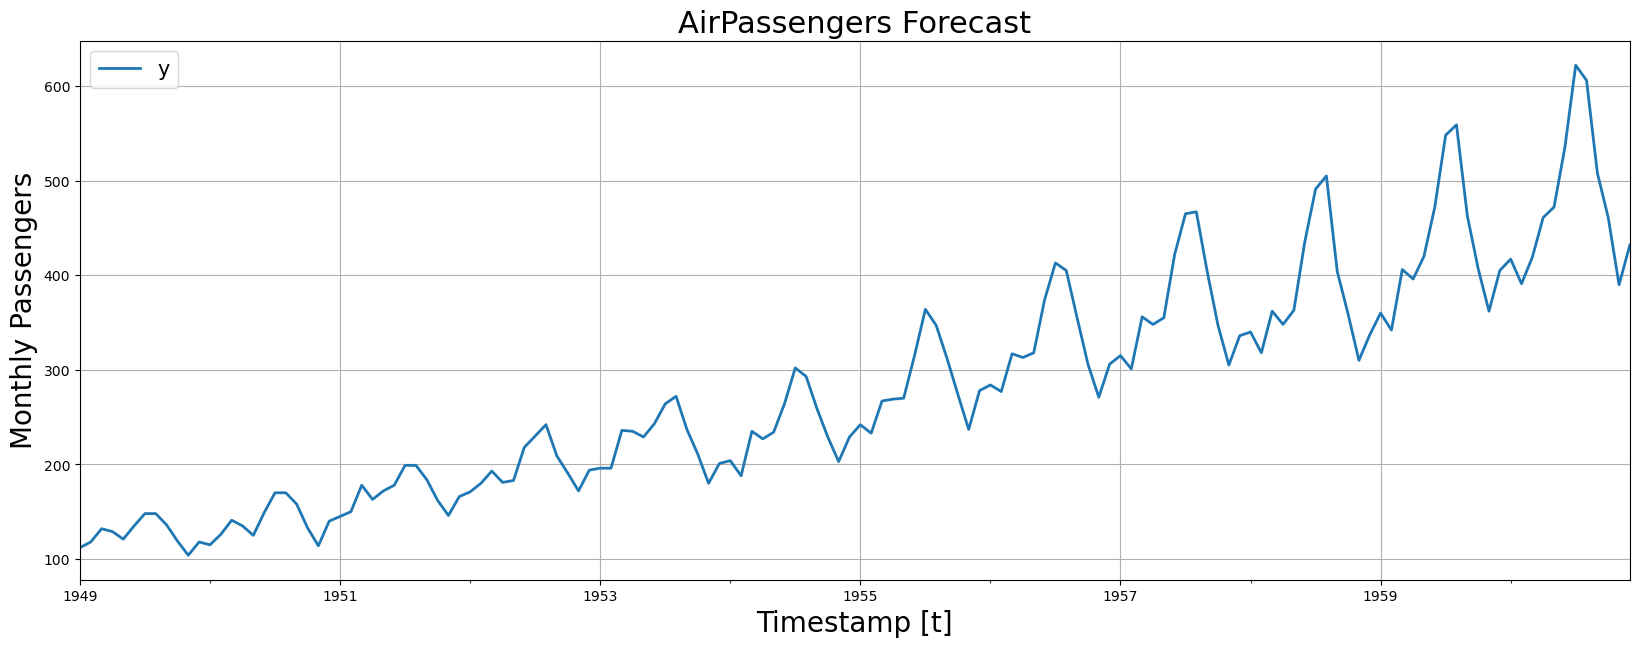

In [ ]:
#We are going to plot the ARIMA predictions, and the prediction intervals.
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = AirPassengersDF.set_index('ds')

plot_df[['y']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
n_static_features = 3
n_series = 5

static_features = np.random.uniform(low=0.0, high=1.0, 
                        size=(n_series, n_static_features))
static_df = pd.DataFrame.from_records(static_features, 
                   columns = [f'static_{i}'for i in  range(n_static_features)])
static_df['unique_id'] = np.arange(n_series)

In [ ]:
static_df

,static_0,static_1,static_2,unique_id
0,0.268844,0.875946,0.047605,0
1,0.995151,0.376025,0.497579,1
2,0.136613,0.060934,0.319290,2
3,0.084419,0.918999,0.820050,3
4,0.774360,0.685072,0.113191,4


# 3. Panel AirPassengers Data

Extension to classic Box & Jenkins airline data. Monthly totals of international airline passengers, 1949 to 1960.

It includes two series with static, temporal and future exogenous variables, that can help to explore the performance of models like `NBEATSx` and `TFT`.

In [ ]:
#| export

# Declare Panel Data
unique_id = np.concatenate([['Airline1']*len(AirPassengers), ['Airline2']*len(AirPassengers)])
ds = np.tile(
    pd.date_range(
        start='1949-01-01', periods=len(AirPassengers), freq=pd.offsets.MonthEnd()
    ).to_numpy(), 
    2,
)
y = np.concatenate([AirPassengers, AirPassengers+300])

AirPassengersPanel = pd.DataFrame({'unique_id': unique_id, 'ds': ds, 'y': y})

# For future exogenous variables
# Declare SeasonalNaive12 and fill first 12 values with y
snaive = AirPassengersPanel.groupby('unique_id')['y'].shift(periods=12).reset_index(drop=True)
AirPassengersPanel['trend'] = range(len(AirPassengersPanel))
AirPassengersPanel['y_[lag12]'] = snaive.fillna(AirPassengersPanel['y'])

# Declare Static Data
unique_id = np.array(['Airline1', 'Airline2'])
airline1_dummy = [0, 1]
airline2_dummy = [1, 0]
AirPassengersStatic = pd.DataFrame({'unique_id': unique_id,
                                    'airline1': airline1_dummy,
                                    'airline2': airline2_dummy})

AirPassengersPanel.groupby('unique_id').tail(4)

,unique_id,ds,y,trend,y_[lag12]
140,Airline1,1960-09-30,508.0,140,463.0
141,Airline1,1960-10-31,461.0,141,407.0
142,Airline1,1960-11-30,390.0,142,362.0
143,Airline1,1960-12-31,432.0,143,405.0
284,Airline2,1960-09-30,808.0,284,763.0
285,Airline2,1960-10-31,761.0,285,707.0
286,Airline2,1960-11-30,690.0,286,662.0
287,Airline2,1960-12-31,732.0,287,705.0


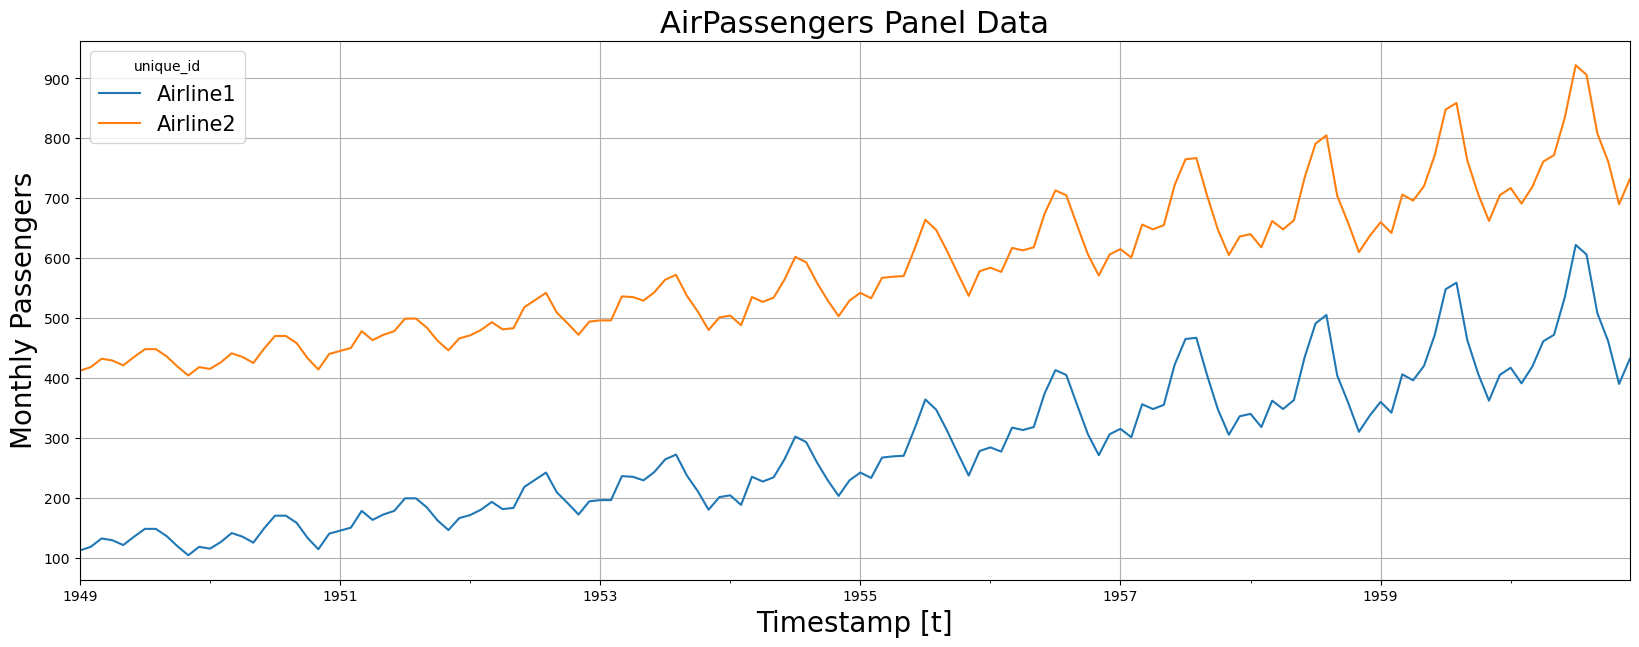

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = AirPassengersPanel.set_index('ds')

plot_df.groupby('unique_id')['y'].plot(legend=True)
ax.set_title('AirPassengers Panel Data', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(title='unique_id', prop={'size': 15})
ax.grid()

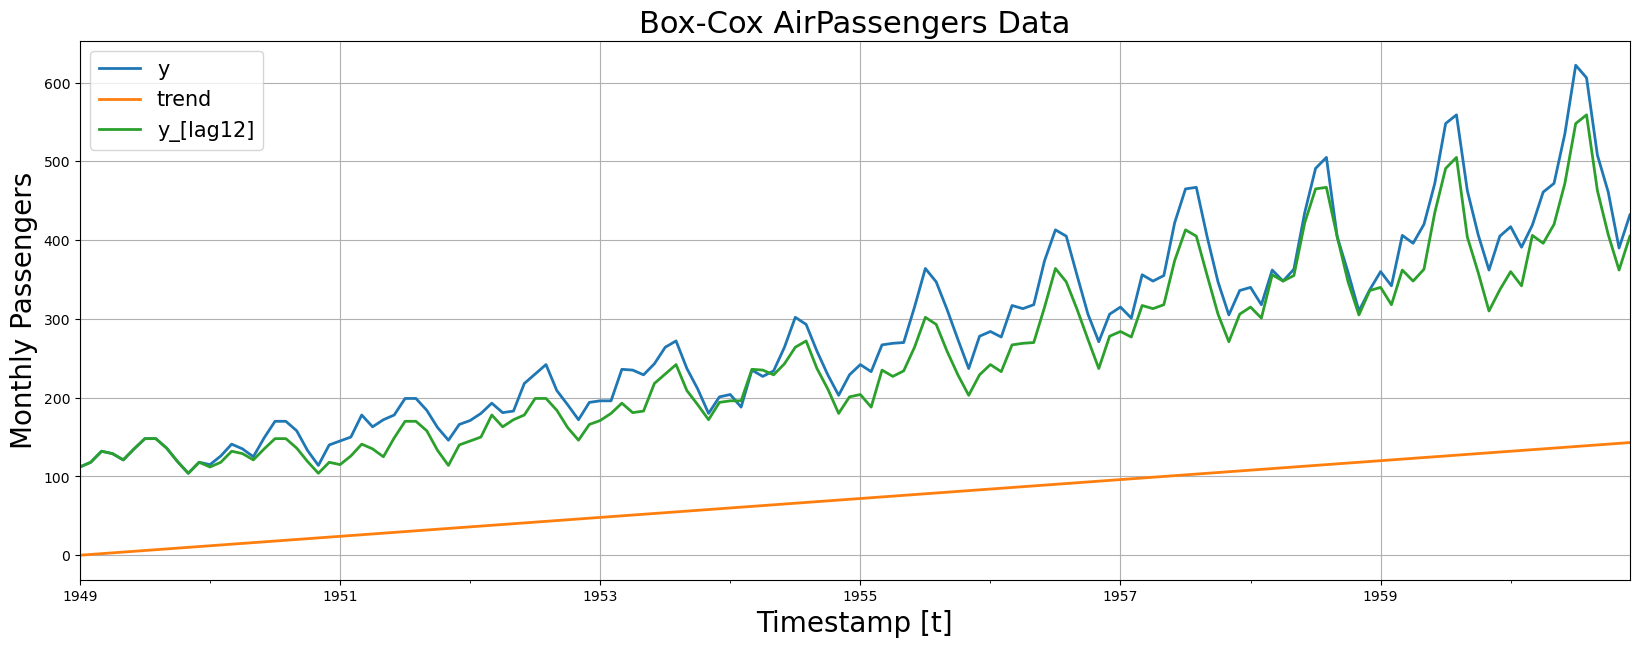

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = AirPassengersPanel[AirPassengersPanel.unique_id=='Airline1'].set_index('ds')

plot_df[['y', 'trend', 'y_[lag12]']].plot(ax=ax, linewidth=2)
ax.set_title('Box-Cox AirPassengers Data', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# 4. Time Features

We have developed a utility that generates normalized calendar features for use as absolute positional embeddings in Transformer-based models. These embeddings capture seasonal patterns in time series data and can be easily incorporated into the model architecture. Additionally, the features can be used as exogenous variables in other models to inform them of calendar patterns in the data.

**References**<br>
- [Haoyi Zhou, Shanghang Zhang, Jieqi Peng, Shuai Zhang, Jianxin Li, Hui Xiong, Wancai Zhang. "Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"](https://arxiv.org/abs/2012.07436)<br>

In [ ]:
#| export
class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex):
        return print('Overwrite with corresponding feature')

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    if freq_str not in ['Q', 'M', 'MS', 'W', 'D', 'B', 'H', 'T', 'S']:
        raise Exception('Frequency not supported')
    
    if freq_str in ['Q','M', 'MS']:
        return [cls() for cls in [MonthOfYear]]
    elif freq_str == 'W':
        return [cls() for cls in [DayOfMonth, WeekOfYear]]
    elif freq_str in ['D','B']:
        return [cls() for cls in [DayOfWeek, DayOfMonth, DayOfYear]]
    elif freq_str == 'H':
        return [cls() for cls in [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear]]
    elif freq_str == 'T':
        return [cls() for cls in [MinuteOfHour, HourOfDay, DayOfWeek, DayOfMonth, DayOfYear]]
    else:
        return [cls() for cls in [SecondOfMinute, MinuteOfHour, HourOfDay, DayOfWeek, DayOfMonth, DayOfYear]]

def augment_calendar_df(df, freq='H'):
    """
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]
    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    df = df.copy()

    freq_map = {
        'Q':['month'],
        'M':['month'],
        'MS':['month'],
        'W':['monthday', 'yearweek'],
        'D':['weekday','monthday','yearday'],
        'B':['weekday','monthday','yearday'],
        'H':['dayhour','weekday','monthday','yearday'],
        'T':['hourminute','dayhour','weekday','monthday','yearday'],
        'S':['minutesecond','hourminute','dayhour','weekday','monthday','yearday']
    }

    ds_col = pd.to_datetime(df.ds.values)
    ds_data = np.vstack([feat(ds_col) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)
    ds_data = pd.DataFrame(ds_data, columns=freq_map[freq])
    
    return pd.concat([df, ds_data], axis=1), freq_map[freq]

In [ ]:
AirPassengerPanelCalendar, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')
AirPassengerPanelCalendar.head()

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1949-01-31,112.0,0,112.0,-0.500000
1,Airline1,1949-02-28,118.0,1,118.0,-0.409091
2,Airline1,1949-03-31,132.0,2,132.0,-0.318182
3,Airline1,1949-04-30,129.0,3,129.0,-0.227273
4,Airline1,1949-05-31,121.0,4,121.0,-0.136364


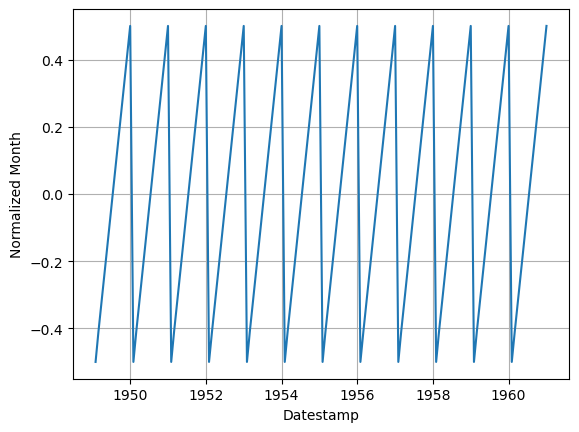

In [ ]:
plot_df = AirPassengerPanelCalendar[AirPassengerPanelCalendar.unique_id=='Airline1'].set_index('ds')
plt.plot(plot_df['month'])
plt.grid()
plt.xlabel('Datestamp')
plt.ylabel('Normalized Month')
plt.show()

In [ ]:
#| export
def get_indexer_raise_missing(idx: pd.Index, vals: List[str]) -> List[int]:
    idxs = idx.get_indexer(vals)
    missing = [v for i, v in zip(idxs, vals) if i == -1]
    if missing:
        raise ValueError(f'The following values are missing from the index: {missing}')
    return idxs

# 5. Prediction Intervals

In [ ]:
#| export

class PredictionIntervals:
    """Class for storing prediction intervals metadata information."""

    def __init__(
        self,
        n_windows: int = 2,
        method: str = "conformal_distribution",
    ):
        """ 
        n_windows : int
            Number of windows to evaluate.
        method : str, default is conformal_distribution
            One of the supported methods for the computation of prediction intervals:
            conformal_error or conformal_distribution
        """
        if n_windows < 2:
            raise ValueError(
                "You need at least two windows to compute conformal intervals"
            )
        allowed_methods = ["conformal_error", "conformal_distribution"]
        if method not in allowed_methods:
            raise ValueError(f"method must be one of {allowed_methods}")
        self.n_windows = n_windows
        self.method = method

    def __repr__(self):
        return f"PredictionIntervals(n_windows={self.n_windows}, method='{self.method}')"

In [ ]:
#| export
def add_conformal_distribution_intervals(
    model_fcsts: np.array, 
    cs_df: DFType,
    model: str,
    cs_n_windows: int,
    n_series: int,
    horizon: int,
    level: Optional[List[Union[int, float]]] = None,
    quantiles: Optional[List[float]] = None,
) -> Tuple[np.array, List[str]]:
    """
    Adds conformal intervals to a `fcst_df` based on conformal scores `cs_df`.
    `level` should be already sorted. This strategy creates forecasts paths
    based on errors and calculate quantiles using those paths.
    """
    assert level is not None or quantiles is not None, "Either level or quantiles must be provided"
    
    if quantiles is None and level is not None:
        alphas = [100 - lv for lv in level]
        cuts = [alpha / 200 for alpha in reversed(alphas)]
        cuts.extend(1 - alpha / 200 for alpha in alphas)
    elif quantiles is not None:
        cuts = quantiles
    
    scores = cs_df[model].to_numpy().reshape(n_series, cs_n_windows, horizon)
    scores = scores.transpose(1, 0, 2)
    # restrict scores to horizon
    scores = scores[:,:,:horizon]
    mean = model_fcsts.reshape(1, n_series, -1)
    scores = np.vstack([mean - scores, mean + scores])
    scores_quantiles = np.quantile(
        scores,
        cuts,
        axis=0,
    )
    scores_quantiles = scores_quantiles.reshape(len(cuts), -1).T
    if quantiles is None and level is not None:
        lo_cols = [f"{model}-lo-{lv}" for lv in reversed(level)]
        hi_cols = [f"{model}-hi-{lv}" for lv in level]
        out_cols = lo_cols + hi_cols
    elif quantiles is not None:
        out_cols = [f"{model}-ql{q}" for q in quantiles]

    fcsts_with_intervals = np.hstack([model_fcsts, scores_quantiles])

    return fcsts_with_intervals, out_cols

In [ ]:
#| export
def add_conformal_error_intervals(
    model_fcsts: np.array, 
    cs_df: DFType, 
    model: str,
    cs_n_windows: int,
    n_series: int,
    horizon: int,
    level: Optional[List[Union[int, float]]] = None,
    quantiles: Optional[List[float]] = None,
) -> Tuple[np.array, List[str]]:
    """
    Adds conformal intervals to a `fcst_df` based on conformal scores `cs_df`.
    `level` should be already sorted. This startegy creates prediction intervals
    based on the absolute errors.
    """
    assert level is not None or quantiles is not None, "Either level or quantiles must be provided"

    if quantiles is None and level is not None:
        cuts = [lv / 100 for lv in level]
    elif quantiles is not None:
        cuts = quantiles

    mean = model_fcsts.ravel()
    scores = cs_df[model].to_numpy().reshape(n_series, cs_n_windows, horizon)
    scores = scores.transpose(1, 0, 2)
    # restrict scores to horizon
    scores = scores[:,:,:horizon]
    scores_quantiles = np.quantile(
        scores,
        cuts,
        axis=0,
    )
    scores_quantiles = scores_quantiles.reshape(len(cuts), -1)
    if quantiles is None and level is not None:
        lo_cols = [f"{model}-lo-{lv}" for lv in reversed(level)]
        hi_cols = [f"{model}-hi-{lv}" for lv in level]
        out_cols = lo_cols + hi_cols
        scores_quantiles = np.vstack([mean - scores_quantiles[::-1], mean + scores_quantiles]).T
    elif quantiles is not None:
        out_cols = []
        scores_quantiles_ls = []
        for i, q in enumerate(quantiles):
            out_cols.append(f"{model}-ql{q}")
            if q < 0.5:
                scores_quantiles_ls.append(mean - scores_quantiles[::-1][i])
            elif q > 0.5:
                scores_quantiles_ls.append(mean + scores_quantiles[i])
            else:
                scores_quantiles_ls.append(mean)
        scores_quantiles = np.vstack(scores_quantiles_ls).T                    

    fcsts_with_intervals = np.hstack([model_fcsts, scores_quantiles])

    return fcsts_with_intervals, out_cols

In [ ]:
#| export
def get_prediction_interval_method(method: str):
    available_methods = {
        "conformal_distribution": add_conformal_distribution_intervals,
        "conformal_error": add_conformal_error_intervals,
    }
    if method not in available_methods.keys():
        raise ValueError(
            f"prediction intervals method {method} not supported "
            f'please choose one of {", ".join(available_methods.keys())}'
        )
    return available_methods[method]

In [ ]:
#| export
def level_to_quantiles(level: List[Union[int, float]]) -> List[float]:
    """
    Converts a list of levels to a list of quantiles.
    """
    level_set = set(level)
    return sorted(list(set(sum([[(50 - l / 2) / 100, (50 + l / 2) / 100] for l in level_set], []))))

def quantiles_to_level(quantiles: List[float]) -> List[Union[int, float]]:
    """
    Converts a list of quantiles to a list of levels.
    """
    quantiles_set = set(quantiles)
    return sorted(set([int(round(100 - 200 * (q * (q < 0.5) + (1 - q) * (q >= 0.5)), 2)) for q in quantiles_set]))

In [ ]:
#| hide
# Test level_to_quantiles
level_base = [80, 90]
quantiles_base = [0.05, 0.1, 0.9, 0.95]
quantiles = level_to_quantiles(level_base)
level = quantiles_to_level(quantiles_base)

assert quantiles == quantiles_base
assert level == level_base